In [181]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import random 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchinfo import summary
import pandas as pd
import os

from tqdm import trange
import inspect
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

from myUtils import *
from plottingUtils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
#hyperparameters

data_dir = ".\datasets\PJM_power"
fname = "COMED_hourly.csv"

sample_len = 360
step = 1
target_len = 120
batch_size = 64
steps_in_day = 24

HID_DIM = 64
RNN_LAYERS = 4
LIN_LAYERS = 2
DROPOUT = 0.5
N_SIN_TERMS = 16
N_PARAMS = 2 + 3*N_SIN_TERMS

desired_features = None

In [183]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)

Using cuda device
2.0.1+cu117


In [184]:



def apply_vals(vals, seq):
    '''
    vals: [batch size, n_features, n_params]
    
    '''
    batch_size = vals.shape[0]
    n_features = vals.shape[1]
    vals = vals.unsqueeze(3)
    #print("vals", vals.shape, vals.device)
    seq = seq.unsqueeze(0).unsqueeze(1).repeat(batch_size, n_features, 1).float()
    #print("seq", seq.shape, seq.device)
    #print("x0", vals[:,:,0].shape)
    #print("a", vals[:,:,2::2].shape)
    x =  vals[:,:, 3::3] + torch.matmul(vals[:,:, 4::3], seq.unsqueeze(2))
    #print("x", x.shape, x.device)
    #print("a", vals[:,:,2::3].shape)
    out = vals[:,:,0] + vals[:,:,1] * seq + (vals[:,:, 2::3] * torch.sin(x)).sum(2)
    #print("out", out.shape, out.device)
    return out.permute(0, 2, 1).contiguous()


In [185]:
class Fourier(nn.Module):
    def __init__(self, n_features, n_params, device, hid_dim = 64, rnn_layers = 2, lin_layers=1 ,dropout=0.5):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = rnn_layers
        self.device = device

        self.rnn = nn.GRU(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=rnn_layers,
            dropout=dropout,
            batch_first=True,
        )

        # create fc
        self.fc = nn.Sequential()
        for i in range(lin_layers):
            self.fc.add_module(f"lin{i}", nn.Linear(hid_dim * rnn_layers, hid_dim * rnn_layers))
            self.fc.add_module(f"relu{i}", nn.ReLU())
        self.fc.add_module(f"lin{lin_layers}", nn.Linear(hid_dim * rnn_layers, n_params * n_features))


    def forward(self, src):
        # src = [batch size, src len, n features]

        batch_size = src.shape[0]
        n_features = src.shape[2]

        _, hidden = self.rnn(src)

        # hidden = [n layers, batch size, hid dim]
        hidden = hidden.permute(1, 0, 2).reshape(batch_size, -1).contiguous()
        # hidden = [batch size, n layers * hid dim]
        output = self.fc(hidden)
        # output = [batch size, n params * n features]
        return output.reshape(batch_size, n_features, -1)

In [186]:
# model fitting

def train(
    dataloader,
    model,
    loss_fn,
    optimizer,
    iter_count=None,
    visibility=True,
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    optimizer: used optimizer
    iter_count: number of iterations, if None then dataloader length
    desired_features: list of features to be used in loss calculation, if None then all features
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: boolean, if True then show progress bar
    """
    assert not (
        inspect.isgenerator(dataloader) and iter_count is None
    ), "generator must have specified size"
    if iter_count is None:
        iter_count = len(dataloader.dataset)

    data_iterator = iter(dataloader)
    model.train()
    average_loss = 0

    r = trange(iter_count) if visibility else range(iter_count)

    for _ in r:
        x, y = next(data_iterator)
        x, y = x.to(device), y.to(device)
        # Compute prediction error

        pred = model(x)
        value = apply_vals(pred, torch.arange(y.shape[1]).to(device))
        
        loss = loss_fn(value, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        average_loss += loss.item()

    average_loss /= iter_count

    return average_loss


def eval(
    dataloader, 
    model, 
    loss_fn, 
    iter_count=None, 
    visibility=True
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    iter_count: number of iterations, if None then dataloader length
    desired_features: list of features to be used in loss calculation
    visibility: boolean, if True then show progress bar
    """
    if iter_count is None:
        iter_count = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        r = trange(iter_count) if visibility else range(iter_count)
        for _ in r:
            x, y = next(data_iterator)
            x, y = x.to(device), y.to(device)

            pred = model(x)
            value = apply_vals(pred, torch.arange(y.shape[1]).to(device))

            test_loss += loss_fn(value, y).item()

    test_loss /= iter_count

    return test_loss


def fit_model(
    model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    scheduler,
    epochs=5,
    train_iter_count=None,
    val_iter_count=None,
    visibility = 0,
    save_model = False
):
    '''
    model: model to train
    train_dataloader: iterable
    val_dataloader: iterable
    loss_fn: loss function
    optimizer: used optimizer
    epochs: number of epochs
    train_iter_count: number of training iterations
    val_iter_count: number of validation iterations
    desired_features: list of features to be used in loss calculation
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: 0 - no progress bar, 1 - progress bar for entire training, 2 - progress bar for each epoch
    save_model: boolean, if True then save model with lowest validation loss
    '''
    history = {
        "train": {"loss": []},
        "val": {"loss": []},
    }
    total_time_start = time.time()
    r = trange(epochs) if visibility == 1 else range(epochs)

    min_val_loss = np.inf

    for t in r:
        if visibility == 2:
            print(f"Epoch {t+1}\n-------------------------------")
            print("Test")
        train_loss = train(
            train_dataloader,
            model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            iter_count=train_iter_count,
            visibility=(visibility == 2),
        )
        if visibility == 2:
            print("Eval")
        val_loss = eval(
            val_dataloader,
            model,
            loss_fn=loss_fn,
            iter_count=val_iter_count,
            visibility=(visibility == 2),
        )

        scheduler.step(val_loss)

        if min_val_loss > val_loss and save_model:
            min_val_loss = val_loss
            torch.save(model, "model.pth")
        if visibility == 2:
            print(f"Train Error: Avg loss: {train_loss:.4f} ")
            print(f"Validation Error: Avg loss: {val_loss:.4f} \n")
        if visibility == 1:
            r.set_postfix({"Avg": f"{val_loss:.4f}", "Min": f"{min_val_loss:.4f}"})
        history["train"]["loss"].append(train_loss)
        history["val"]["loss"].append(val_loss)

    total_time_end = time.time()
    total_duration = total_time_end - total_time_start
    
    average_duration = total_duration / epochs
    if visibility != 0:
        print(f"Total Duration: {print_duration(total_duration)}")
        print(f"Average Duration: {print_duration(average_duration)}")
        print(f"Min Validation Loss: {min_val_loss:.4f}")

    
    return history

In [187]:
# preprocessing

df = extract_dataframe(data_dir, fname)
#df = add_features(df, steps_in_day=steps_in_day)

header, float_data = extract_data(df)
normalized_data, mean, std = normalize_data(float_data)

In [188]:
timesteps = len(float_data)
print(f'{timesteps} timesteps')

66497 timesteps


In [189]:
# generators

train_max_index = int(timesteps * 0.7)

train_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=0,
    max_index=train_max_index,
    shuffle=True,
    step=step,
    batch_size=batch_size,
    
)

val_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=train_max_index+1,
    max_index=timesteps,
    shuffle=True,
    step=step,
    batch_size=batch_size
)



COMED_MW


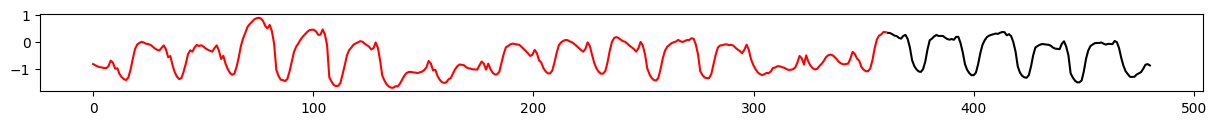

In [190]:
samples, targets = next(train_generator)
for feature in range(samples.shape[-1]):
    print(header[feature])
    plot_samples(samples, targets, feature, figsize=(15,1))

#assert False

In [191]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)



In [192]:
# instantiate model

N_FEATURES = float_data.shape[1]

model = Fourier(
    n_features=N_FEATURES,
    n_params=N_PARAMS,
    device=device,
    hid_dim=HID_DIM,
    rnn_layers=RNN_LAYERS,
    lin_layers=LIN_LAYERS,
    dropout=DROPOUT,
).to(device)
# init weights

model.apply(init_weights)

# model = Iterative(N_SAMPLES, HID_DIM, N_LAYERS, DROPOUT).to(device)
print(model)

Fourier(
  (rnn): GRU(1, 64, num_layers=4, batch_first=True, dropout=0.5)
  (fc): Sequential(
    (lin0): Linear(in_features=256, out_features=256, bias=True)
    (relu0): ReLU()
    (lin1): Linear(in_features=256, out_features=256, bias=True)
    (relu1): ReLU()
    (lin2): Linear(in_features=256, out_features=50, bias=True)
  )
)


In [193]:
summary(
    model,
    input_size=(10, sample_len, N_FEATURES),
    col_names=["input_size", "output_size", "num_params", "trainable", "kernel_size"],
    col_width=15,
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Trainable       Kernel Shape
Fourier                                  [10, 360, 1]    [10, 1, 50]     --              True            --
├─GRU: 1-1                               [10, 360, 1]    [10, 360, 64]   87,744          True            --
├─Sequential: 1-2                        [10, 256]       [10, 50]        --              True            --
│    └─Linear: 2-1                       [10, 256]       [10, 256]       65,792          True            --
│    └─ReLU: 2-2                         [10, 256]       [10, 256]       --              --              --
│    └─Linear: 2-3                       [10, 256]       [10, 256]       65,792          True            --
│    └─ReLU: 2-4                         [10, 256]       [10, 256]       --              --              --
│    └─Linear: 2-5                       [10, 256]       [10, 50]        12,850          True            --
Total params: 232,

In [194]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 232,178 trainable parameters


In [195]:
# Fit model

loss_fn = nn.MSELoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

history = fit_model(
    model,
    train_dataloader=train_generator,
    train_iter_count=100,
    val_dataloader=val_generator,
    val_iter_count=50,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=200,
    save_model=True,
    visibility=1
)

100%|██████████| 200/200 [08:02<00:00,  2.41s/it, Avg=2688.8784, Min=0.7005] 

Total Duration: 0:8:2.27
Average Duration: 0:0:2.410
Min Validation Loss: 0.7005


History:


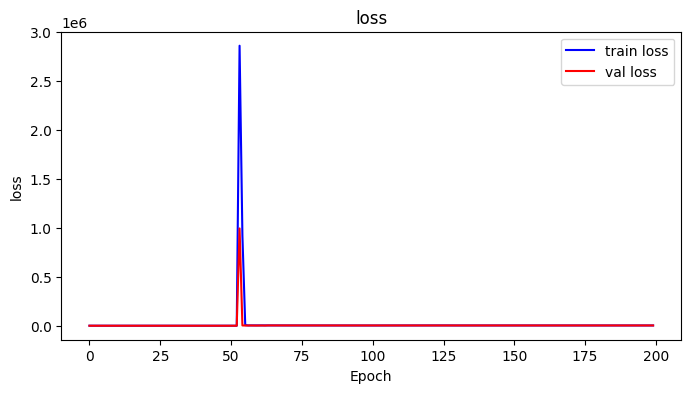

In [196]:
plot_history(history, ylim=None)

In [197]:


def make_predictions(model, samples, len):
    with torch.no_grad():
        values = model(samples.to(device))
        #print(values[0])
        output = apply_vals(values, torch.arange(len).to(device))
    return output





torch.Size([64, 120, 1])
COMED_MW


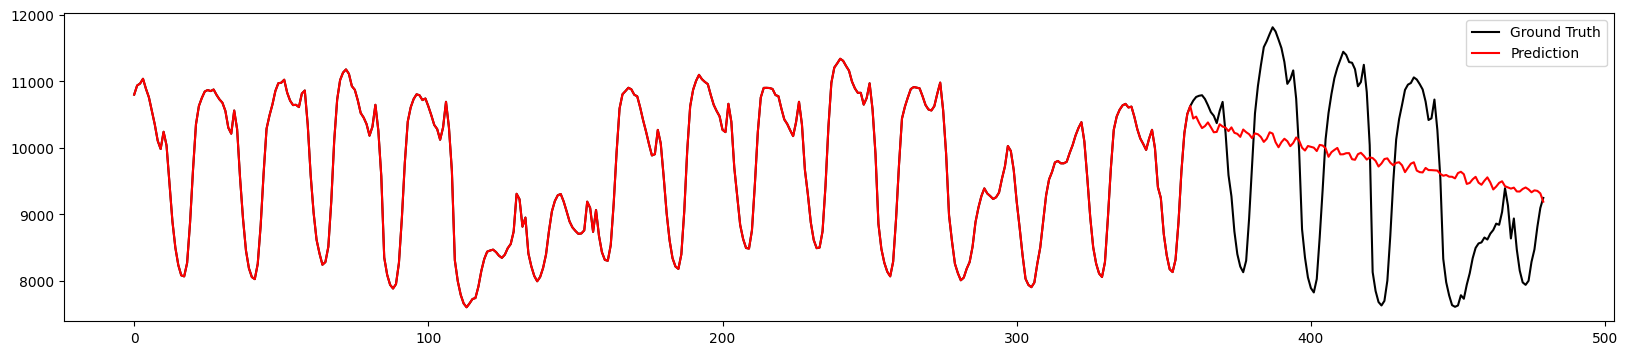

torch.Size([64, 120, 1])
COMED_MW


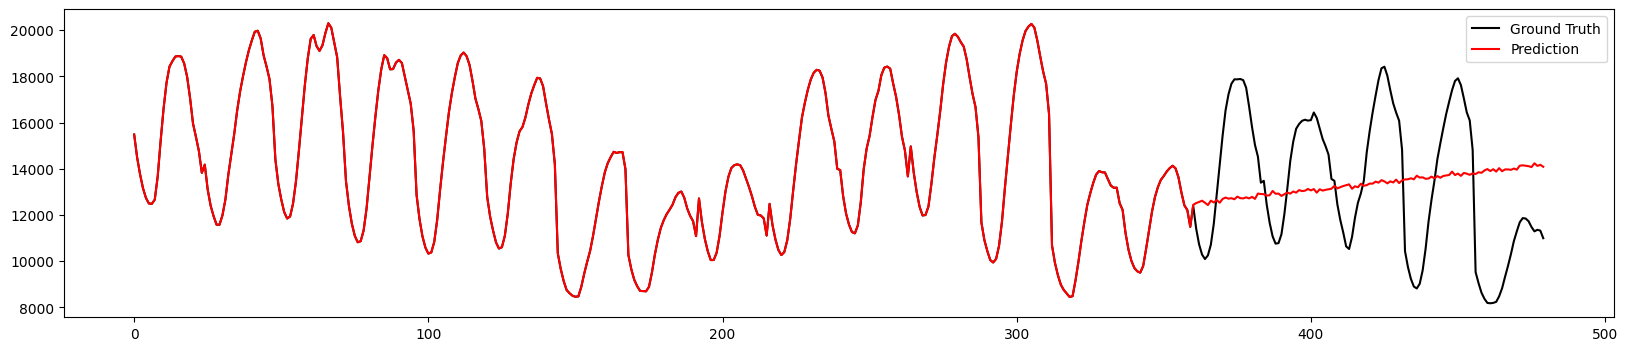

torch.Size([64, 120, 1])
COMED_MW


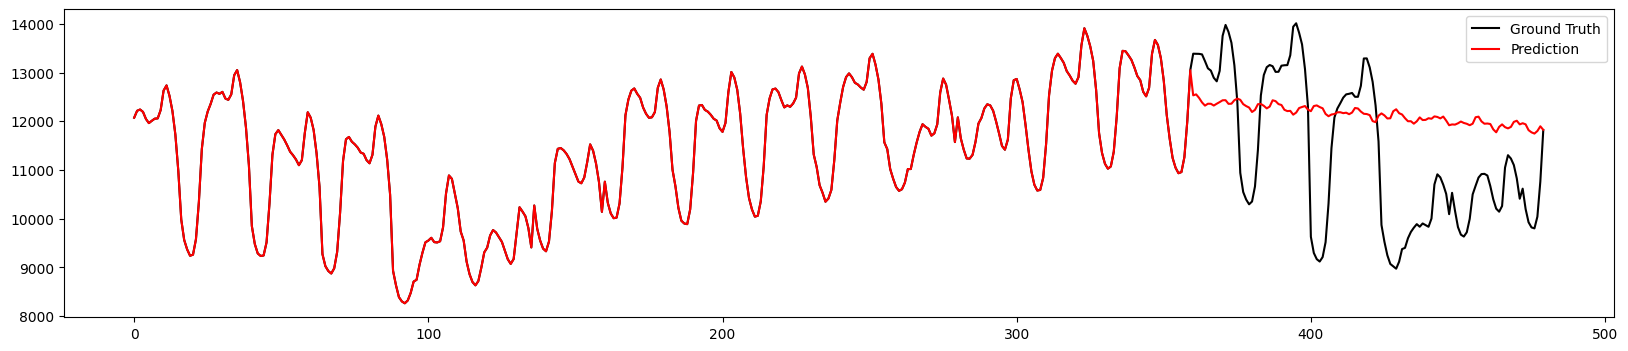

torch.Size([64, 120, 1])
COMED_MW


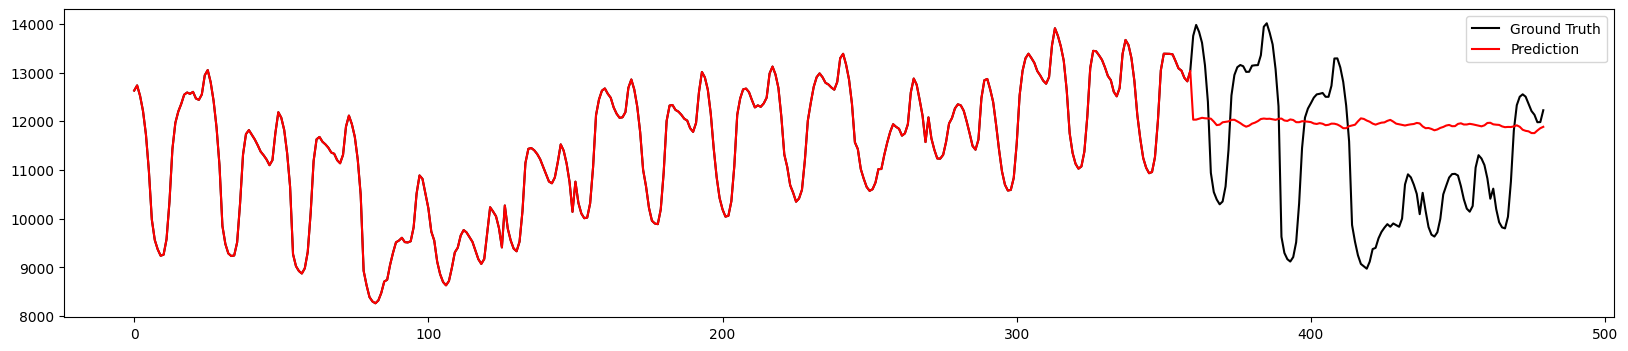

torch.Size([64, 120, 1])
COMED_MW


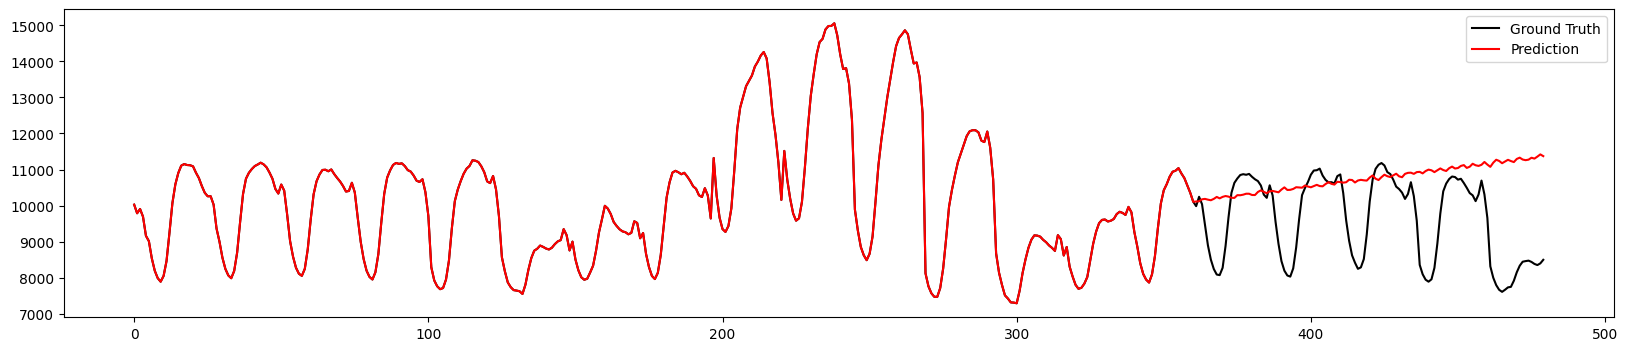

torch.Size([64, 120, 1])
COMED_MW


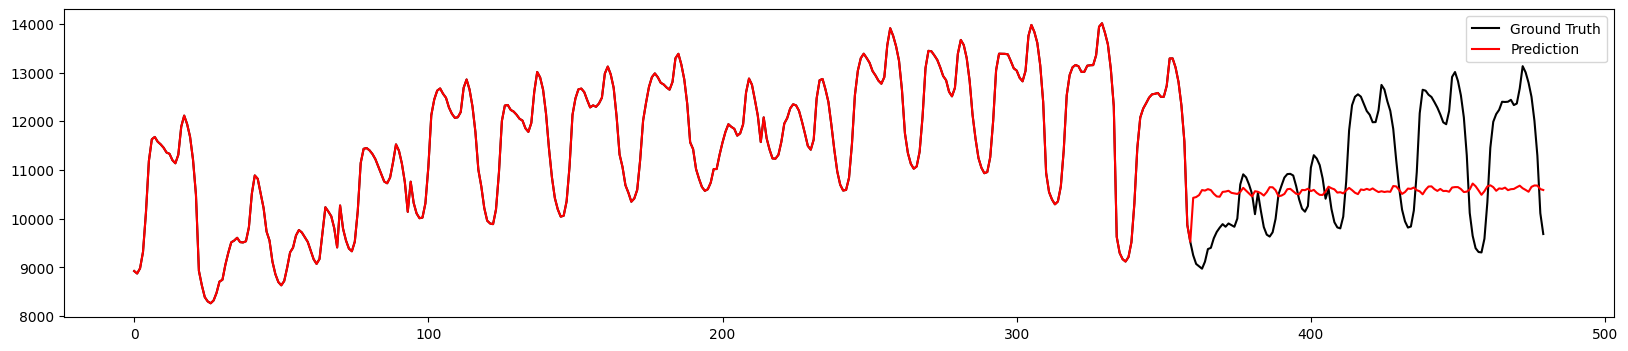

torch.Size([64, 120, 1])
COMED_MW


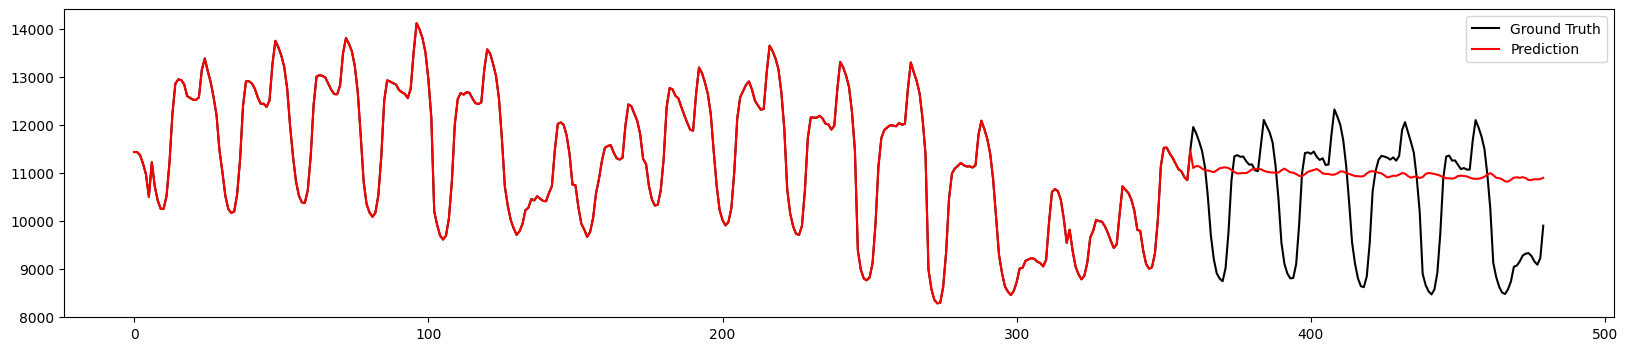

torch.Size([64, 120, 1])
COMED_MW


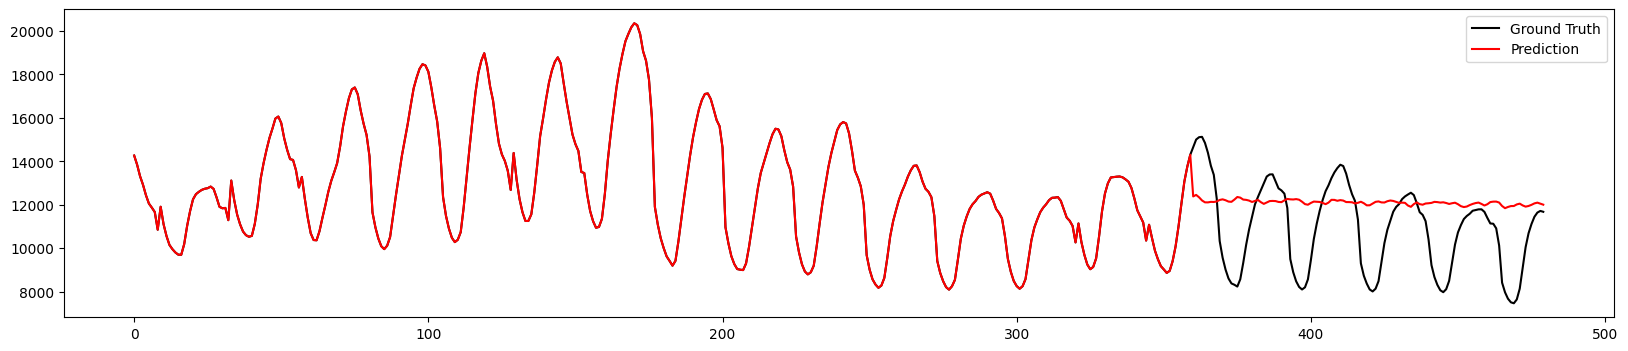

torch.Size([64, 120, 1])
COMED_MW


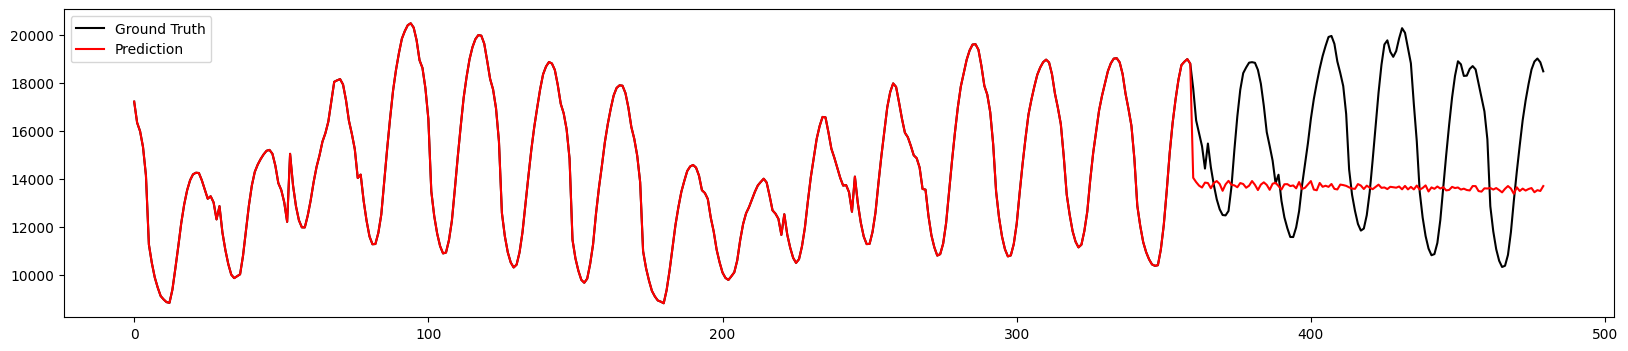

torch.Size([64, 120, 1])
COMED_MW


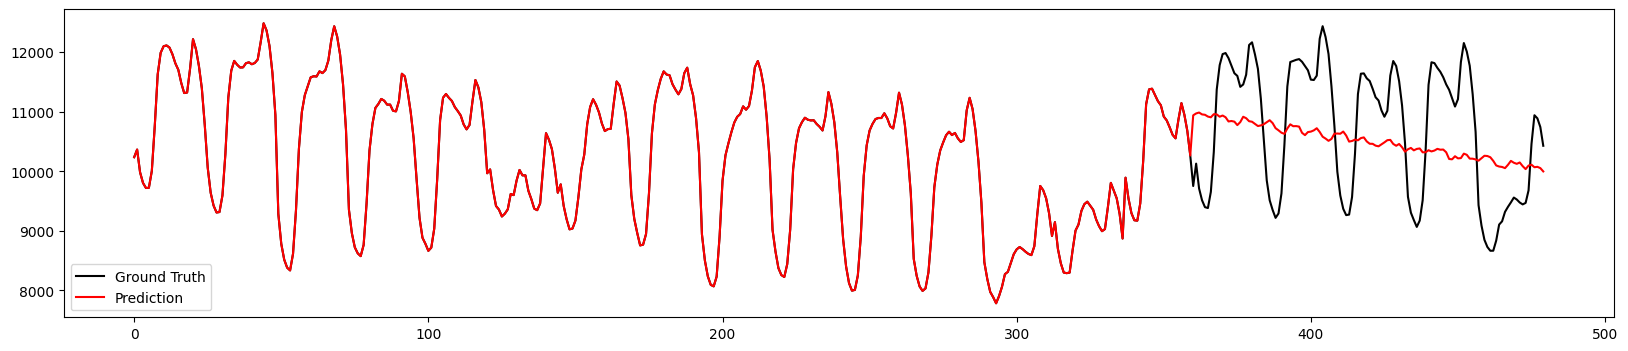

In [198]:
model = torch.load("model.pth")


for _ in range(10):
    model.eval()
    samples, targets = next(val_generator)
    output = make_predictions(model, samples, targets.shape[1])
    print(output.shape)

    plot_predictions(header, samples, targets, output, mean, std)